In [12]:
# basic
import numpy as np
import pandas as pd

# diagnostics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# models
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# cosmetics
import warnings
warnings.filterwarnings('ignore')

# Preparation

In [15]:
data = pd.read_csv('data/cleaned_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,permno,date,ticker,log_size,log_bm,log_pcf,mom,strev,vol,roa,roe,log_age_lb,price,log_to,rf,rm,ols_3m_d,ols_1y_d,ols_5y_m,f_ols_1y_d
0,10495,1970-02-27,A,6.470490,-0.210721,1.350408,-0.578969,0.072728,0.064539,0.165,0.080,3.788477,29.500,16.413102,0.006098,0.057959,1.374051,0.853367,1.140401,0.930236
1,10495,1970-03-31,A,6.457554,0.579978,0.988053,-0.522672,0.002921,0.064813,0.228,0.086,3.790459,29.125,16.642725,0.005685,-0.004832,0.987517,0.853597,1.139011,0.959935
2,10495,1970-04-30,A,6.386543,0.579978,0.988053,-0.536403,-0.068671,0.065203,0.228,0.086,3.792313,27.125,16.194663,0.005072,-0.104827,0.893758,0.889231,1.119059,0.971245
3,10495,1970-05-29,A,6.363201,0.579978,0.988053,-0.404250,-0.023041,0.066323,0.228,0.086,3.794103,26.500,16.513551,0.005263,-0.064084,1.008542,0.940364,1.115537,0.962626
4,10495,1970-06-30,A,6.264160,0.579978,1.494476,-0.113006,-0.077634,0.066461,0.228,-0.001,3.796074,24.000,15.603262,0.005736,-0.052295,1.023860,0.958821,1.093605,0.949843


In [16]:
selected_features = ['log_size', 'log_pcf', 'log_to', 'vol', 'ols_3m_d', 'ols_1y_d', 'ols_5y_m']

y = data['f_ols_1y_d']
X = data[selected_features]
for col in X.columns:
    col_mean = X[col].mean()
    col_std = X[col].std()
    X[col] = (X[col] - col_mean) / col_std
    X[col] = X[col].clip(lower=-3, upper=3) # normalize features to [-3,3]

# Split train, val, test
test_time_start = data['date'].max() - pd.DateOffset(years=5) # last 5 years as testme 
val_time_start = test_time_start - pd.DateOffset(years=2) # last 2 years as val
data_test = data[data['date'] >= test_time_start]
data_val = data[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
data_train = data[data['date'] < val_time_start]
X_test = X[data['date'] >= test_time_start]
X_val = X[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
X_train = X[data['date'] < val_time_start]
y_test = y[data['date'] >= test_time_start]
y_val = y[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
y_train = y[data['date'] < val_time_start]

# special train set for time-series cross validation (automanaged by sklearn)
X = X[data['date'] < test_time_start]
y = y[data['date'] < test_time_start]

In [22]:
best_model = xgb.XGBRegressor()
best_model.load_model('models/XGB.json')
beta_pred = best_model.predict(X_test)

In [23]:
beta_pred # predicted beta in last 5 years

array([1.2827435, 1.2893898, 1.2072872, ..., 1.3300282, 1.3281208,
       1.3565236], dtype=float32)

In [61]:
data_test['ret'] = data_test.groupby('permno')['price'].pct_change().shift(-1) # subsequent realized return 
data_test['beta_pred'] = beta_pred
data_test

,permno,date,ticker,log_size,log_bm,log_pcf,mom,strev,vol,roa,...,rf,rm,ols_3m_d,ols_1y_d,ols_5y_m,f_ols_1y_d,ret,beta_pred,quantile_ML,quantile_CAPM
160,87432,2017-02-28,A,9.712424,-1.184170,2.916960,0.281641,0.047581,0.052133,0.126000,...,0.00038,0.036072,1.662649,1.383502,1.074503,1.143525,0.030604,1.282743,"(1.229, 1.333]","(1.051, 1.077]"
161,87432,2017-03-31,A,9.743325,-1.298283,3.052491,0.263334,0.033178,0.051843,0.131000,...,0.00023,0.001883,1.552978,1.339715,1.091389,1.095898,0.041233,1.289390,"(1.229, 1.333]","(1.077, 1.109]"
162,87432,2017-04-28,A,9.783729,-1.298283,3.052491,0.266627,0.041235,0.051170,0.131000,...,0.00057,0.011297,1.354115,1.319740,1.091748,1.122594,0.096094,1.207287,"(1.143, 1.229]","(1.077, 1.109]"
163,87432,2017-05-31,A,9.875479,-1.298283,3.052491,0.192405,0.096093,0.050763,0.131000,...,0.00066,0.011226,1.190489,1.380906,1.083063,1.167509,-0.017070,1.205639,"(1.143, 1.229]","(1.077, 1.109]"
164,87432,2017-06-30,A,9.855268,-1.398367,3.163194,0.315478,-0.014864,0.049726,0.134000,...,0.00066,0.008827,1.031930,1.342271,1.132810,1.192931,0.008093,1.155785,"(1.143, 1.229]","(1.109, 1.157]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832480,13305,2021-10-29,ZWS,8.389951,-1.269401,4.684083,0.702602,0.097639,0.083569,0.111339,...,0.00000,0.066594,1.171684,1.393592,1.221833,1.167084,-0.033903,1.350126,"(1.333, 1.483]","(1.157, 1.656]"
832481,13305,2021-11-30,ZWS,8.355450,-1.491655,4.490522,0.637272,-0.033135,0.082289,0.111339,...,0.00000,-0.015391,1.055995,1.395640,1.214939,1.178668,0.038516,1.329828,"(1.229, 1.333]","(1.157, 1.656]"
832482,13305,2021-12-31,ZWS,8.393239,-1.491655,4.490522,0.552135,0.038516,0.082199,0.111339,...,0.00000,0.030891,1.148859,1.351214,1.247024,1.177447,-0.160989,1.330028,"(1.229, 1.333]","(1.157, 1.656]"
832483,13305,2022-01-31,ZWS,8.217708,-1.491655,4.490522,0.632080,-0.160989,0.082194,0.111339,...,0.00000,-0.062437,1.082226,1.232000,1.267200,1.236233,0.064833,1.328121,"(1.229, 1.333]","(1.157, 1.656]"


# Question a
Do the ML betas correspond more closely with subsequent realized returns than the CAPM betas?

Provide both statistical and clear easy-to-read visual evidence

In [28]:
# get CAPM betas
beta_CAPM = data_test['ols_5y_m']
beta_CAPM

160       1.074503
161       1.091389
162       1.091748
163       1.083063
164       1.132810
            ...   
832480    1.221833
832481    1.214939
832482    1.247024
832483    1.267200
832484    1.242563
Name: ols_5y_m, Length: 95842, dtype: float64

In [82]:
data_test['quantile_ML'] = pd.qcut(data_test['beta_pred'], q = 5)
data_test['quantile_CAPM'] = pd.qcut(data_test['ols_5y_m'], q = 5)

quantile_ret_ML = data_test.groupby('quantile_ML')['ret'].mean().reset_index()
quantile_ret_CAPM = data_test.groupby('quantile_CAPM')['ret'].mean().reset_index()

Text(0.5, 1.0, 'Forecast Beta vs. Realized Return')

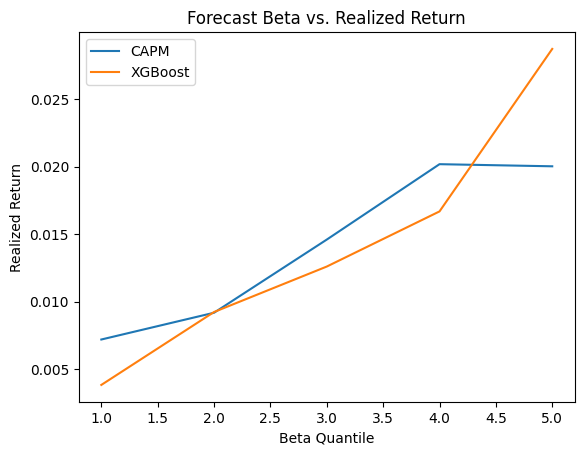

In [83]:
plt.plot(np.arange(1,6), quantile_ret_CAPM['ret'], label = 'CAPM')
plt.plot(np.arange(1,6), quantile_ret_ML['ret'], label = 'XGBoost')
plt.legend()
plt.xlabel('Beta Quantile')
plt.ylabel('Realized Return')
plt.title('Forecast Beta vs. Realized Return')

In [84]:
corr_ML = data_test['beta_pred'].corr(data_test['ret'])
corr_CAPM = data_test['ols_5y_m'].corr(data_test['ret'])

display(corr_ML)
display(corr_CAPM)

0.025027585804994

0.016036922968695435

# Question b
Calculate monthly decile portfolio returns to a BAB decile portfolio using:
 - CAPM betas
 - ML betas

In [85]:
# CAPM
port_return_CAPM = data_test.groupby(['quantile_CAPM','date'])['ret'].mean().reset_index()
port_return_CAPM['acc_ret'] = port_return_CAPM.groupby('quantile_CAPM')['ret'].cumsum()
port_return_CAPM

,quantile_CAPM,date,ret,acc_ret
0,"(0.337, 0.929]",2017-02-28,-0.003668,-0.003668
1,"(0.337, 0.929]",2017-03-31,0.009875,0.006207
2,"(0.337, 0.929]",2017-04-28,-0.004530,0.001677
3,"(0.337, 0.929]",2017-05-31,0.006784,0.008461
4,"(0.337, 0.929]",2017-06-30,0.012458,0.020919
...,...,...,...,...
300,"(1.109, 1.656]",2021-10-29,-0.029726,0.790332
301,"(1.109, 1.656]",2021-11-30,0.052470,0.842801
302,"(1.109, 1.656]",2021-12-31,-0.046218,0.796583
303,"(1.109, 1.656]",2022-01-31,0.019767,0.816351


Text(0.5, 1.0, 'Decile Portofolio Returns by CAPM BAB')

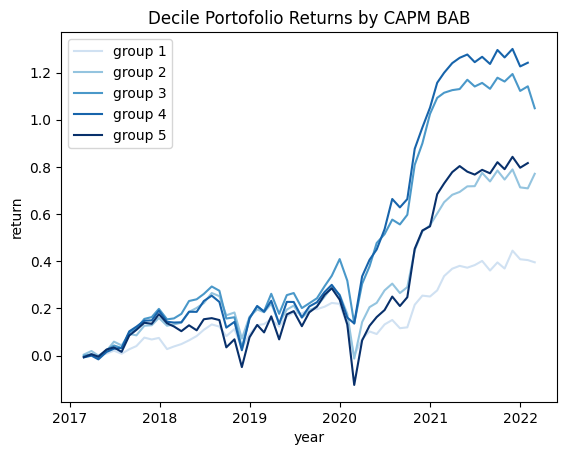

In [88]:
idx = 1
for group, group_data in port_return_CAPM.groupby('quantile_CAPM'):
    color = plt.cm.Blues(idx/5)
    plt.plot(group_data['date'], group_data['acc_ret'], label = f"group {idx}", color = color)
    idx += 1

plt.legend()
plt.xlabel('year')
plt.ylabel('return')
plt.title('Decile Portofolio Returns by CAPM BAB')

In [89]:
# ML
port_return_ML = data_test.groupby(['quantile_ML','date'])['ret'].mean().reset_index()
port_return_ML['acc_ret'] = port_return_ML.groupby('quantile_ML')['ret'].cumsum()

Text(0.5, 1.0, 'Decile Portofolio Returns by ML BAB')

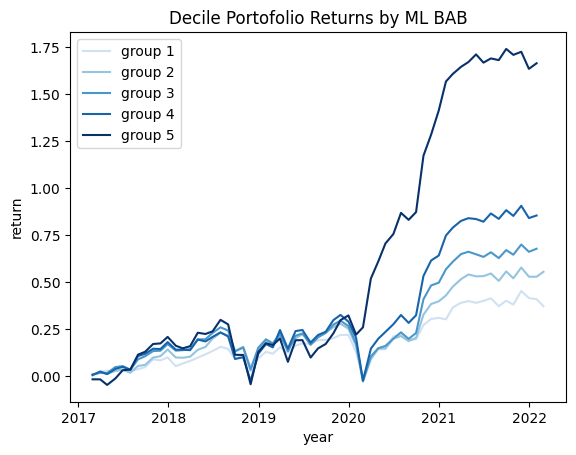

In [91]:
idx = 1
for group, group_data in port_return_ML.groupby('quantile_ML'):
    color = plt.cm.Blues(idx/5)
    plt.plot(group_data['date'], group_data['acc_ret'], label = f"group {idx}", color = color)
    idx += 1

plt.legend()
plt.xlabel('year')
plt.ylabel('return')
plt.title('Decile Portofolio Returns by ML BAB')

# Question c
Compare the fundamental characteristics of high and low BAB factor portfolios

In [96]:
features = ['log_size', 'log_bm', 'log_pcf', 'mom', 'strev', 'vol', 'roa', 'roe', 'log_age_lb', 'price', 'log_to', 'ols_1y_d','ols_3m_d']

In [97]:
len(features)

13

In [98]:
def plot_feature(feature):
    feature_ML = data_test.groupby(['quantile_ML','date'])[feature].mean().reset_index()

    idx = 1
    for group, group_data in feature_ML.groupby('quantile_ML'):
        color = plt.cm.Blues(idx/5)
        plt.plot(group_data['date'], group_data[feature], label = f"group {idx}", color = color)
        idx += 1

    plt.legend()
    plt.xlabel('year')
    plt.ylabel(feature)
    plt.title(f'Fundamental Characteristics: {feature}')

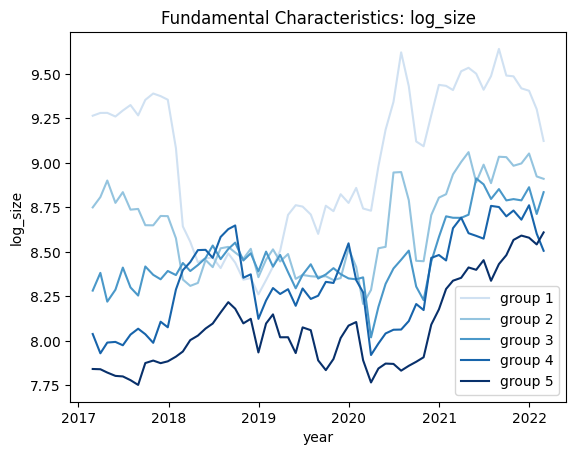

In [99]:
plot_feature(features[0]) # pick

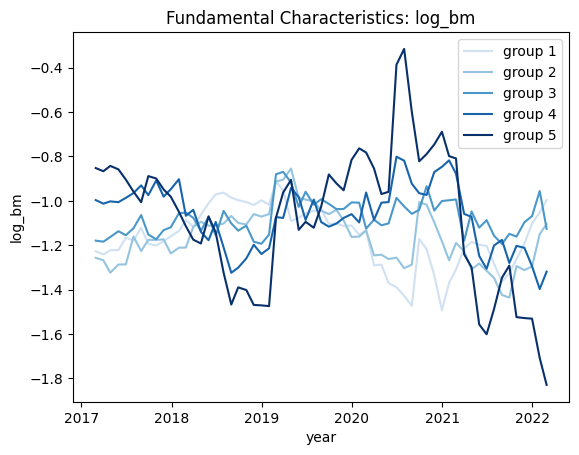

In [100]:
plot_feature(features[1])

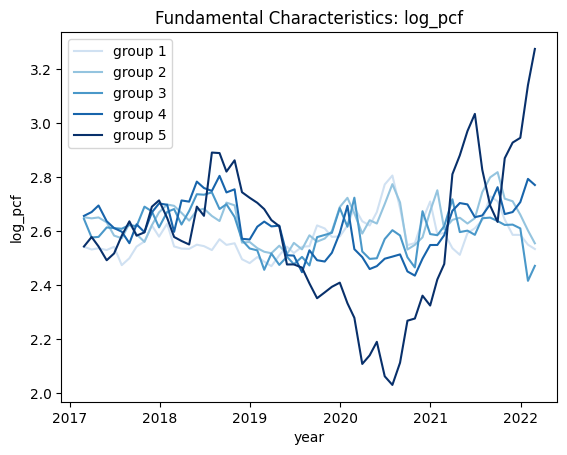

In [101]:
plot_feature(features[2])

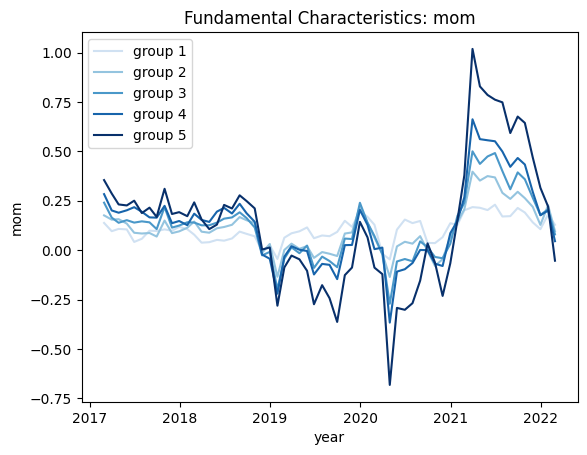

In [102]:
plot_feature(features[3]) # hmm, interesting

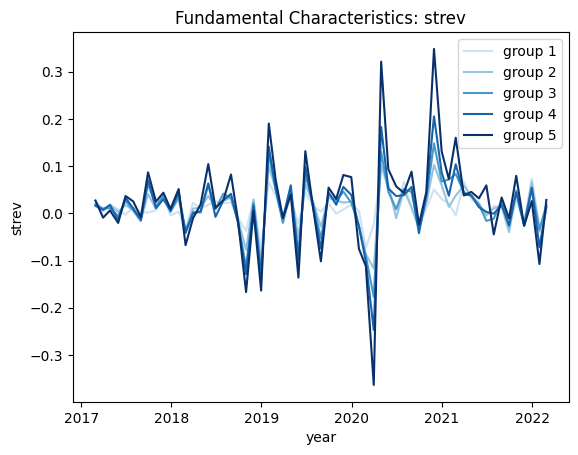

In [103]:
plot_feature(features[4])

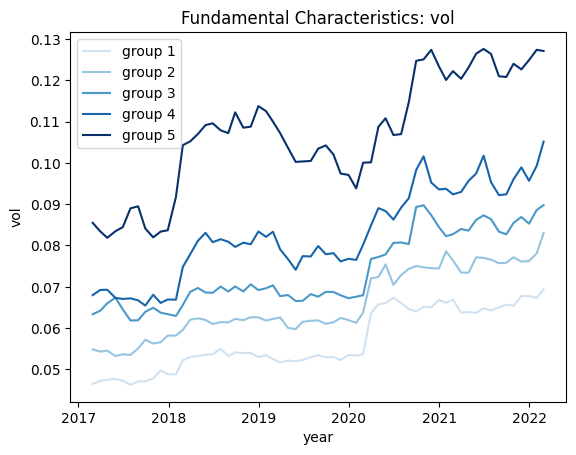

In [104]:
plot_feature(features[5]) # pick

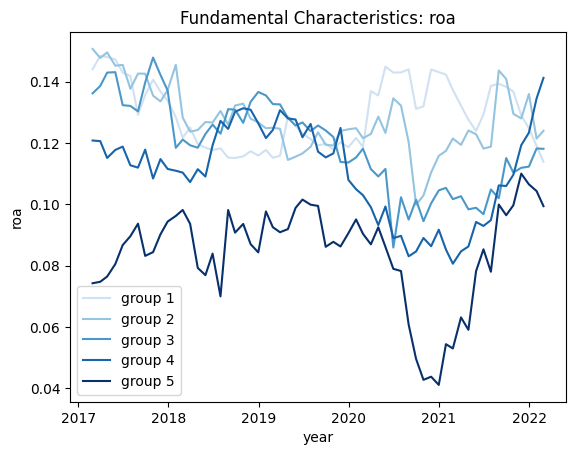

In [105]:
plot_feature(features[6]) # pick

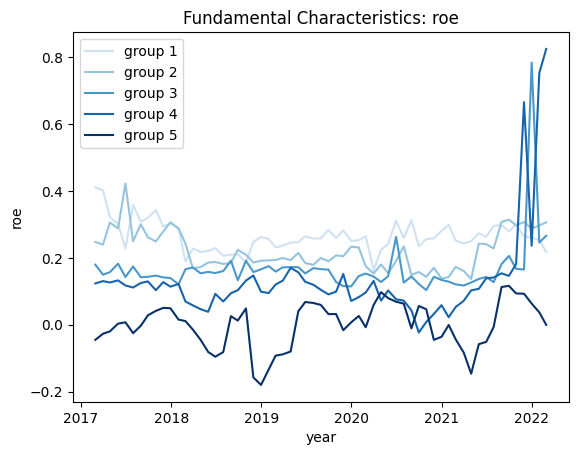

In [106]:
plot_feature(features[7]) # pick

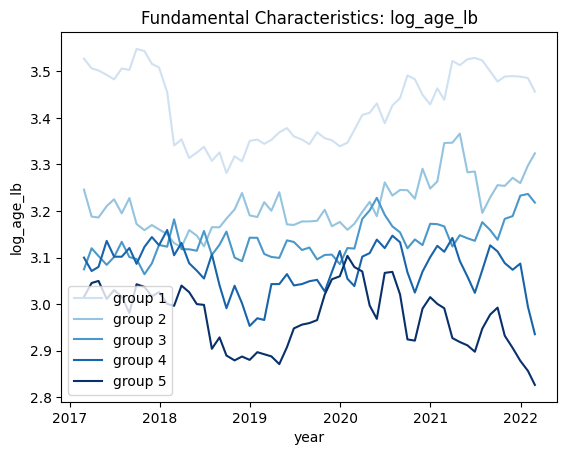

In [107]:
plot_feature(features[8]) # pick

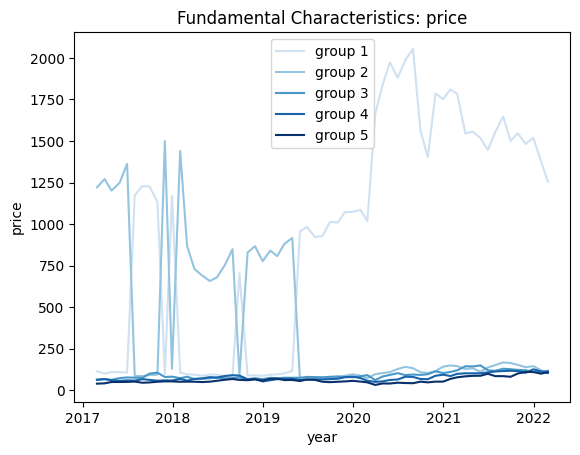

In [108]:
plot_feature(features[9])

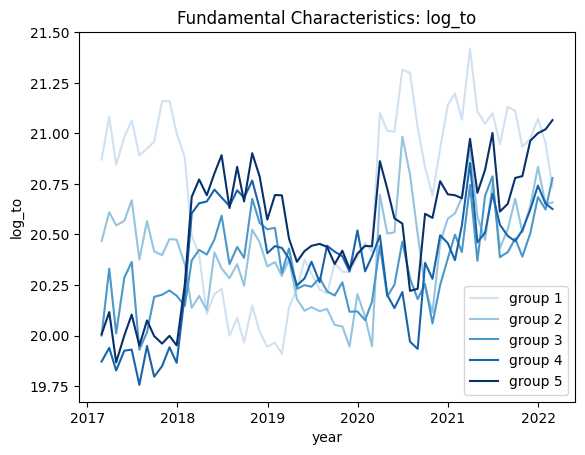

In [110]:
plot_feature(features[10])

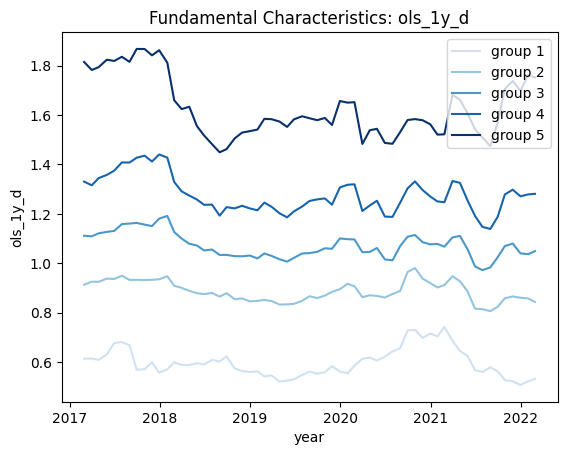

In [111]:
plot_feature(features[11]) # pick

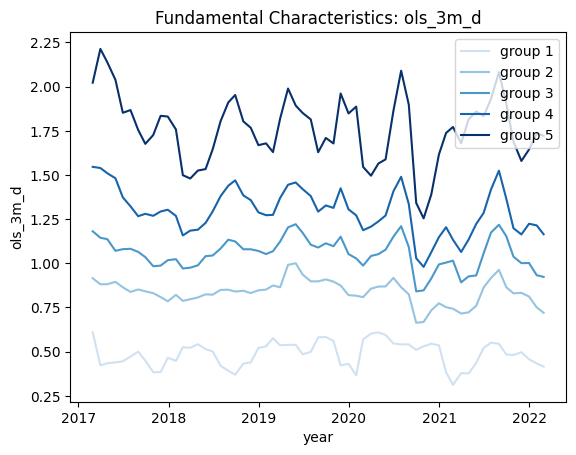

In [112]:
plot_feature(features[12]) # pick. but these 2 need further explanation

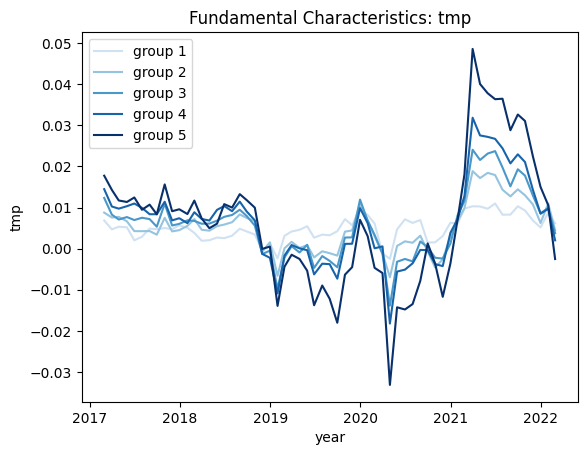

In [117]:
# picked: log_size, (mom), vol, roa, roe, log_age_1b, 2 betas
# start making new features
data_test['tmp'] = data_test['log_pcf']/data_test['log_to']
plot_feature('tmp')